In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


# Preprocess data to create sequences
def preprocess_data():
    """
    Preprocess data to create sequences for RNN.
    This should scale the data and prepare sliding window sequences for RNN input.
    """

    df = pd.read_csv('jena_climate_2009_2016.csv')

    # Handle invalid data or missing values
    temp_column = 'T (degC)' 
    df = df.dropna(subset=[temp_column])

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_temperature = scaler.fit_transform(df[[temp_column]])

    # Create sequences for RNN
    sequence_length = 50  # Sliding window size
    X, y = [], []
    for i in range(len(scaled_temperature) - sequence_length):
        X.append(scaled_temperature[i:i + sequence_length])
        y.append(scaled_temperature[i + sequence_length])

    X = np.array(X)
    y = np.array(y)

    # Split data into training and testing sets
    split = int(len(X) * 0.8)  # 80% training, 20% testing
    train_X, test_X = X[:split], X[split:]
    train_y, test_y = y[:split], y[split:]

    return train_X, train_y, test_X, test_y, scaler

In [25]:
# Create RNN Model
def create_rnn_model(input_shape):
    """
    Create a simple RNN model with the specified input shape.
    """
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=input_shape, activation='tanh'))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [26]:
# Make Predictions
def make_predictions(model, test_X, scaler):
    """
    Generate predictions using the trained RNN model and scale back to original values.
    """
    predictions = model.predict(test_X)

    # Rescale predictions back to original temperature scale
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    return predictions

In [27]:
# Calculate RMSE
def compute_rmse(actual, predicted):
    """
    Calculate RMSE between actual and predicted values.
    """
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f"RMSE: {rmse}")
    return rmse

In [28]:
# Plot actual vs predicted values
def plot_predictions(actual, predicted):
    """
    Plot actual temperature values vs predicted temperature values.
    """
    plt.figure(figsize=(15, 5))
    plt.plot(actual, label="Actual Temperature", color="blue")
    plt.plot(predicted, label="Predicted Temperature", color="orange", linestyle="--")
    plt.xlabel("Time Step")
    plt.ylabel("Temperature (in original scale)")
    plt.title("Comparison of Actual vs Predicted Temperature")
    plt.legend()
    plt.show()

Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10513/10513 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 7.2142e-04 - mae: 0.0081
Epoch 2/5
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 1.5470e-05 - mae: 0.0027
Epoch 3/5
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 1.3736e-05 - mae: 0.0025
Epoch 4/5
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 1.3507e-05 - mae: 0.0025
Epoch 5/5
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 1.3264e-05 - mae: 0.0025
2629/2629 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
RMSE: 0.20624955480021578


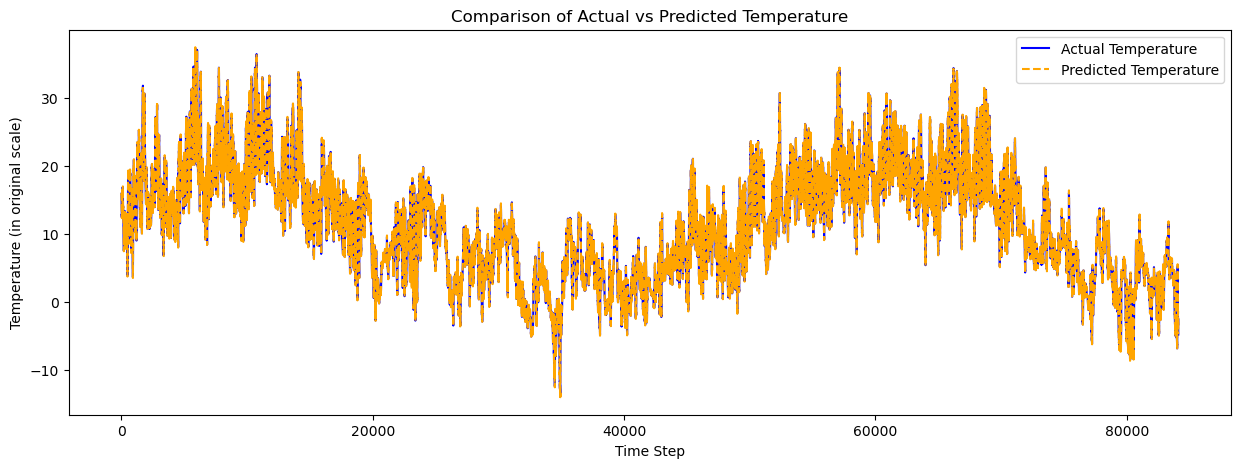

RNN Hyperparameters:
           Parameter   Value
               Units      64
          Activation    relu
Recurrent Activation sigmoid
             Dropout     0.2
   Recurrent Dropout     0.2
           Optimizer    Adam
       Learning Rate   0.001
          Batch Size      64
              Epochs       5


In [29]:
def main():
    # Preprocess the data
    train_X, train_y, test_X, test_y, scaler = preprocess_data()

    # Create the RNN model
    rnn_model = create_rnn_model(input_shape=(train_X.shape[1], train_X.shape[2]))

    # Train the model
    rnn_model.fit(train_X, train_y, epochs=5, batch_size=32, verbose=1)

    # Make predictions on the test data
    predictions = make_predictions(rnn_model, test_X, scaler)

    # Rescale the test_y for RMSE computation
    test_y_rescaled = scaler.inverse_transform(test_y.reshape(-1, 1))

    # Calculate RMSE
    rmse = compute_rmse(test_y_rescaled, predictions)

    # Plot actual vs predicted temperature
    plot_predictions(test_y_rescaled, predictions)

    #Hyperparameter table
    rnn_hyperparameters = {
    "Parameter": [
        "Units", "Activation", "Recurrent Activation", "Dropout", 
        "Recurrent Dropout", "Optimizer", "Learning Rate", "Batch Size", 
        "Epochs"
    ],
    "Value": [
        64, "relu", "sigmoid", 0.2, 0.2, 
        "Adam", 0.001, 64, 5
    ]
    }

    rnn_table = pd.DataFrame(rnn_hyperparameters)
    print("RNN Hyperparameters:")
    print(rnn_table.to_string(index=False))

if __name__ == "__main__":
    main()